In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
# data 
import numpy as np
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Get Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=472). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=663). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1717). ']
RED 	 472
GRN 	 663
BLU 	 1717


In [4]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [5]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
GRN	 ID 	 663
	 z 	 663
BLU	 ID 	 1717
	 z 	 1717


In [6]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

# Prep SEDs

In [7]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [8]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    lamFlam_norm = SED.NormalizeSED_1um(lamR, lamFlam, print=False)
    # get luminosity at 1um
    lum1um = SED.Lum_at1um(lamFlam, lamR, val['z'], )
    # append info
    val['Rest Wavelength'] = lamR
    val['Energy Density'] = lamFlam
    val['Energy Density Normalized at 1um'] = lamFlam_norm
    val['Luminosity at 1um'] = lum1um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
	 Rest Wavelength 	 472
	 Energy Density 	 472
	 Energy Density Normalized at 1um 	 472
	 Luminosity at 1um 	 472
GRN	 ID 	 663
	 z 	 663
	 Rest Wavelength 	 663
	 Energy Density 	 663
	 Energy Density Normalized at 1um 	 663
	 Luminosity at 1um 	 663
BLU	 ID 	 1717
	 z 	 1717
	 Rest Wavelength 	 1717
	 Energy Density 	 1717
	 Energy Density Normalized at 1um 	 1717
	 Luminosity at 1um 	 1717


In [9]:
def GetMaskOfRedshiftsInRange(z,minZ,maxZ):
    return( (z > minZ) & (z <= maxZ) )

def SplitAGNByZ(agnInfo) : 
    # initialize dict with redshift ranges 
    zRanges = [ (0,1),(1,1.5),(1.5,2),(2,3),(3,99) ]
    agnInfo_byZ = {
        '$0 < z \leq 1$'   : {},
        '$1 < z \leq 1.5$' : {},
        '$1.5 < z \leq 2$' : {},
        '$2 < z \leq 3$'   : {},
        '$3 < z \leq 6$'   : {}
    }
    # for each redshift range...
    i=0
    for zrange, agnAtZ in agnInfo_byZ.items() :
        # ... and each red/grn/blu...
        for color, dataDict in agnInfo.items() : 
            agnAtZ[color] = {}
            zmask = GetMaskOfRedshiftsInRange(dataDict['z'],zRanges[i][0],zRanges[i][1])
            # ... and each measurement ...
            for key,data in dataDict.items() : 
                # ... add only agn in this redshift range
                agnAtZ[color][key] = data[zmask]
        # increment to next redshift range 
        i+=1

    return(agnInfo_byZ)


agnInfo_byZ = SplitAGNByZ(agnInfo)

# SED shapes

In [10]:
print(agnInfo_byZ.keys())
print(agnInfo_byZ['$0 < z \\leq 1$'].keys())
print(agnInfo_byZ['$0 < z \\leq 1$']['RED'].keys())

dict_keys(['$0 < z \\leq 1$', '$1 < z \\leq 1.5$', '$1.5 < z \\leq 2$', '$2 < z \\leq 3$', '$3 < z \\leq 6$'])
dict_keys(['RED', 'GRN', 'BLU'])
dict_keys(['ID', 'z', 'Rest Wavelength', 'Energy Density', 'Energy Density Normalized at 1um', 'Luminosity at 1um'])


In [11]:
# get relevant data
panelData = {
    'RED' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Rest Wavelength'],
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Energy Density Normalized at 1um'],
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('r')

    },
    'GRN' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Rest Wavelength'],
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Energy Density Normalized at 1um'],
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('g')
    },
    'BLU' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Rest Wavelength'],
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Energy Density Normalized at 1um'],
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('b')
    }
}

In [12]:
# interpolate
for colorKey, data in panelData.items() :
    f_all = []
    for x,y in zip(data['x'],data['y']) : 
        f_all.append(SED.Interpolate_log(x,y))
    data['f(x)'] = f_all

In [13]:
# returns the interpolaterd slope between xi and xf for each function in f_arr
def GetSlopes(f_arr,xi,xf) : 
    # initialize array 
    m  = np.zeros(np.shape(f_arr))
    # calculate slope for each function 
    for i,f in enumerate(f_arr) : 
        yi = SED.Flog_X(f,xi)
        yf = SED.Flog_X(f,xf)
        m[i] = (np.log10(yf) - np.log10(yi)) / (np.log10(xf) - np.log10(xi))
    # return slope 
    return m

In [14]:
# get slope and boundary points 
for colorKey, data in panelData.items() : 
    data['Slopes'] = { 
        'UV'   : GetSlopes( data['f(x)'], 0.15, 1.00),
        'MIR1' : GetSlopes( data['f(x)'], 1.00, 6.50),
        'MIR2' : GetSlopes( data['f(x)'], 6.50, 10.0)
    }

In [15]:
# returns array containing the 5 panel slope T/F masks 
def SlopePanelMasks(uv_m,mir1_m,mir2_m) : 
    # create bin masks using slopes (m)
    b1 = (uv_m <  -0.3)                  & (mir1_m >= -0.2)
    b2 = (uv_m >= -0.3) & (uv_m <= 0.2)  & (mir1_m >= -0.2)
    b3 = (uv_m >   0.2)                  & (mir1_m >= -0.2)
    b4 = (uv_m >= -0.3)                  & (mir1_m <  -0.2) & (mir2_m >  0.0)
    b5 = (uv_m >= -0.3)                  & (mir1_m <  -0.2) & (mir2_m <= 0.0)
    # put masks in list
    panelMasks = np.array([b1,b2,b3,b4,b5])
    # return masks
    return panelMasks

In [16]:
# applied panel mask to x and y, then returns the result 
def PanelData(x,y,z,panelMasks) :
    # initialize lists 
    x_panel = []
    y_panel = [] 
    z_panel = []
    # bin 
    for mask in panelMasks :
        x_panel.append(x[mask])
        y_panel.append(y[mask])
        z_panel.append(z[mask])
    # return x and y panels
    return x_panel, y_panel, z_panel

In [17]:
# get panels
for colorKey, data in panelData.items() : 
    mask = SlopePanelMasks(data['Slopes']['UV'],data['Slopes']['MIR1'],data['Slopes']['MIR2'])
    data['xp'], data['yp'], data['zp'] = PanelData(data['x'], data['y'], data['z'], mask)

In [31]:
panelData['RED'].keys()

dict_keys(['x', 'y', 'z', 'cmap', 'f(x)', 'Slopes', 'xp', 'yp', 'zp'])

In [32]:
panelData['RED']['Slopes']

{'UV': array([ 9.63683694e-01,  4.76766976e-01,  4.36536075e+00,  1.26483727e-01,
        -1.96802444e+00,  6.31541396e-01,  2.02308827e+00,  3.81381938e+00,
         1.45741680e+00,  1.63770154e+00,  4.72005754e-03,  3.94472503e+00,
         5.48985378e-01,  2.46057079e+00,  2.92501129e+00,  3.52803977e+00,
         2.77531963e+00,  3.92217732e+00,  1.48824822e+00,  3.12511615e+00,
         1.10897662e+00,  2.28844665e+00,  2.65032550e+00,  1.09555513e+00,
         2.55409241e+00,  1.39622325e+00, -2.67638086e-02, -3.66409776e-01,
         2.46648577e+00,  1.86231505e+00,  1.38824838e+00,  2.21121877e+00,
         3.92509132e+00,  8.08462219e-02,  1.13804628e+00, -5.19239338e-01,
         5.58198516e+00,  2.25300678e-01, -4.16767130e-01,  9.82511458e-01,
         4.72451588e-01,  2.06844644e+00, -9.44183418e-02,  2.32711556e+00,
        -2.87252672e-02, -5.25899527e-02, -1.00330789e+00,  1.36395490e-01,
         1.38474799e-01, -7.41962072e-01,  5.07099600e-01,  2.92411214e+00,
      

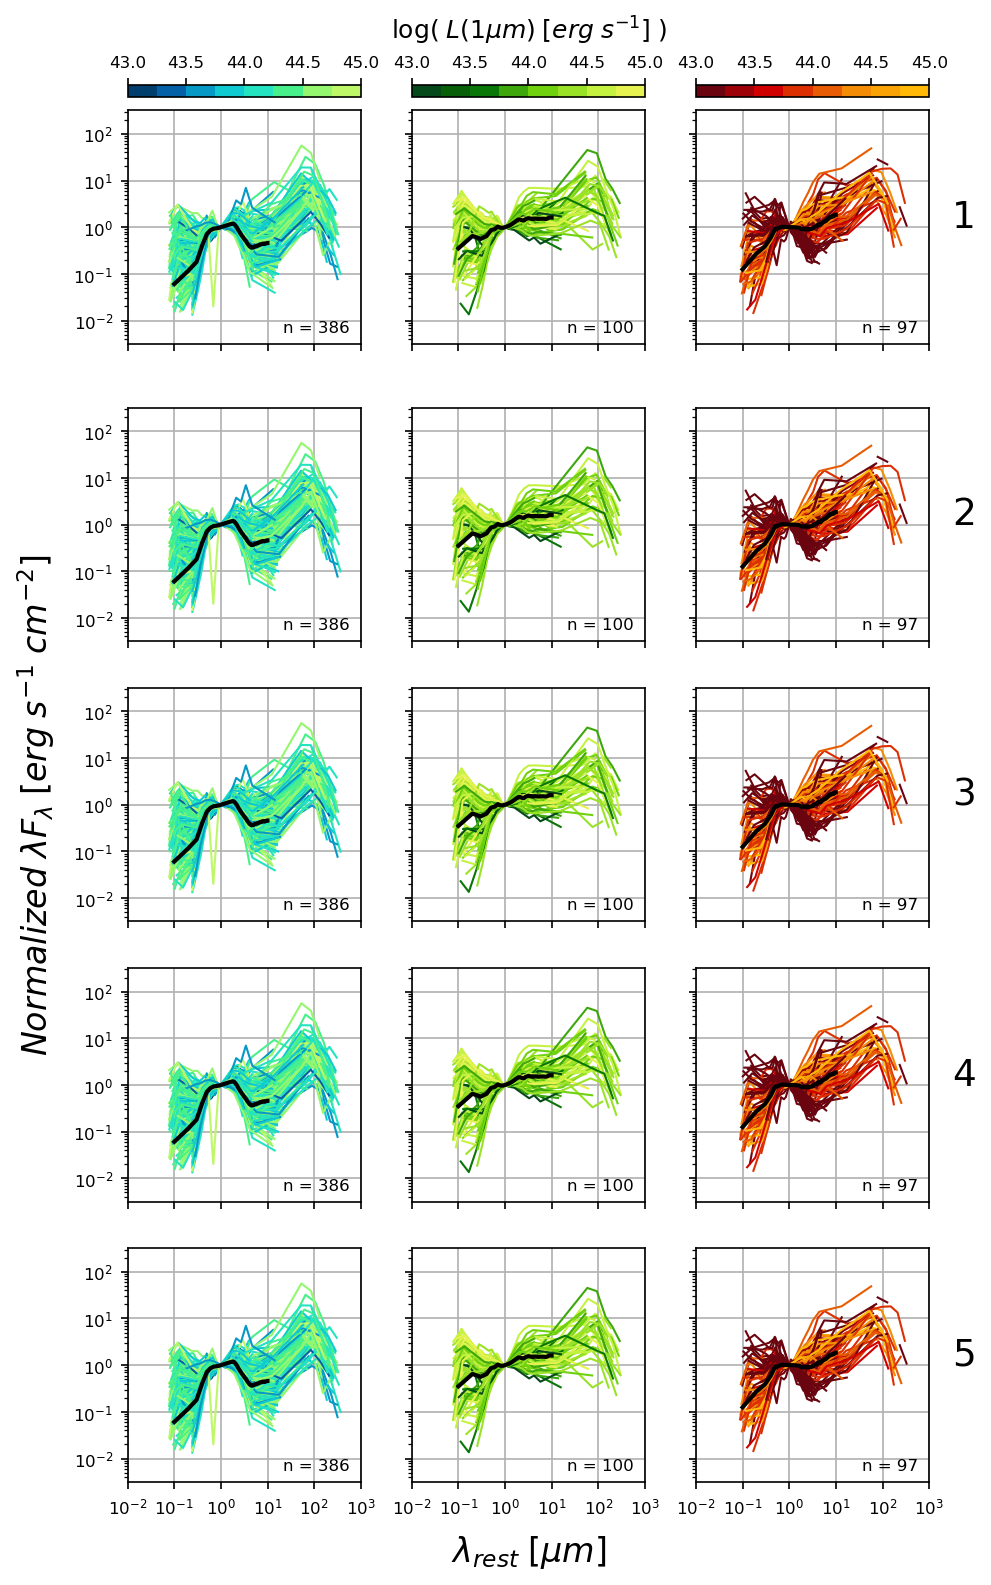

In [49]:
def PlotMosaic(
    panelData,
    cbarRange      # tuple range of colorbar (min, max)
):

    mosaic = [
            ["BLU1", "GRN1", "RED1"],
            ["BLU2", "GRN2", "RED2"],
            ["BLU3", "GRN3", "RED3"],
            ["BLU4", "GRN4", "RED4"],
            ["BLU5", "GRN5", "RED5"]
        ]

    adp.SetStyle()

    fig = plt.figure(figsize=(6.5,10.5), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(
        mosaic, 
        sharex=True, 
        sharey=True
    )

    

    # number of sources of a color 
    n = {
        'RED' : len(panelData['RED']['x'])*100,
        'GRN' : len(panelData['GRN']['x'])*100,
        'BLU' : len(panelData['BLU']['x'])*100
    }

    for i in range(5) : 
        for colorKey in panelData.keys() : 
            # get percent 
            # p = round(np.shape(panelData[colorKey]['xp'][i])[0] / n[colorKey], 2)
            # colormap 
            z_forMap = SED.PrepareCmapValues(panelData[colorKey]['z'], 10**cbarRange[0], 10**cbarRange[1]) [1]
            # plot 
            SED.PlotSED_ax( 
                ax=ax_dict[colorKey+str(i+1)], 
                x=panelData[colorKey]['x'], 
                y=panelData[colorKey]['y'], 
                z=z_forMap, 
                cmap=panelData[colorKey]['cmap'],
                xLabel=False, yLabel=False
            )
        # panel label (1,2,3,4,5 on right side)
        ax = ax_dict["RED"+str(i+1)]
        ax.text(    1.15,                          # x
                    0.50,                          # y 
                    str(i+1),                      # string
                    transform=ax.transAxes,        # use axis coordinants
                    horizontalalignment='center',  # alignment 
                    size=18
            )

    fs = adp.BIG

    for colorKey in panelData.keys() : 
        if(colorKey=='GRN') : 
            clabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$'
        else :
            clabel=''
        # add colorbars 
        SED.PlotColorbar_ax(
            ax=ax_dict[colorKey+"1"], 
            cmap=panelData[colorKey]['cmap'], 
            min=cbarRange[0], max=cbarRange[1], 
            location='top', 
            n_ticks=5, 
            label=clabel)

    # add axis lables 
    ax_dict["BLU3"].set_ylabel('$Normalized \; \lambda F_{\lambda} \; [erg \; s^{-1} \; cm^{-2}]$', fontsize=fs)
    ax_dict["GRN5"].set_xlabel('$\lambda_{rest} \; [\mu m]$', fontsize=fs)

    plt.show()
    plt.close()


    # TODO fix SED curves not showing
    # TODO add percent to each ax

PlotMosaic(
    panelData,
    cbarRange=(43,45)
)

In [26]:
def PlotSED_Row(
        x,                  # x-axis data LIST:   lam [A]
        y,                  # y-axis data LIST:  lamFlam [erg/s/cm2]
        z,                  # colorbar data LIST
        cmapKey,            # colormap options: red, grn, blu, (jet otherwise)
        n_ticks=9,          # number of ticks on colorbar
        showBar=True,       # show the colorbar 
        save='',            # filename to save
        median=True,        # plots a median line when true
        xmin=10**-2,        # plot range 
        xmax=10**3,         #   "    "
        ymin=10**-2.5,      #   "    "
        ymax=10**2.5,       #   "    "
        orientWide=False,   # true for tall, false for wide 
        cbarLabel='$Normalized \; \lambda F_{\lambda} \; at \; 24 \mu m$',
        cbarRange=None,      # tuple range of colorbar (min, max)
        title=None
):
    # check that lists are all same length 
    n = len(x)
    if(n!=len(y) and n!=len(z) and n!=len(cmapKey) ):
        print('[!] Bad inputs')
        return

    # determine subplot shape and parameters
    if(orientWide) :
        nrow = 1
        ncol = len(x)
        figsize = (4+(2*n), 4)
        cbarLocation = 'top'
    else:
        nrow = len(x)
        ncol = 1
        figsize = (6, 2+(2*n))
        cbarLocation = 'right'

    # build figure
    adp.SetStyle() 
    fig = plt.figure(figsize=figsize)    
    ax = []
    for i in range(n):
        ax.append(fig.add_subplot(nrow,ncol,i+1))
   
    # plot each SED
    for i in range(n): 
        # initialize plot settings 
        xTicks=True
        yTicks=True
        xLabel=False
        yLabel=False
        cbarLab=None
        # for wide plot 
        if(orientWide==1) : 
            if(i>0) :           
                yTicks = False
            if(i==int(n/2)):    
                xLabel = True 
                cbarLab = cbarLabel
            if(i==0) :          
                yLabel = True 
        # for tall plot 
        elif(orientWide==0) :
            if(i<n-1):          
                xTicks = False
            if(i==n-1):         
                xLabel = True 
            if(i==int(n/2)):    
                yLabel = True 
                cbarLab = cbarLabel

        # fix type
        if(isinstance(z[i], np.float64)) :
            zi = np.array([z[i]])
        else : 
            zi = z[i]
        # determine color range
        if(cbarRange):
            cbarMin=cbarRange[0]
            cbarMax=cbarRange[1]
            z_forMap = SED.PrepareCmapValues(zi,min=10**cbarMin,max=10**cbarMax)
        else : 
            z_forMap = SED.PrepareCmapValues(zi) 
            cbarMin=min(z_forMap[0])
            cbarMax=max(z_forMap[0])

        # get colormap 
        cmap_use = SED.GetCmap(cmapKey[i], n_ticks)

        # plot on axis 
        SED.PlotSED_ax(
            ax=ax[i],            
            x=x[i],             
            y=y[i],             
            z=z_forMap[1],             
            cmap=cmap_use,          
            median=median,   
            xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
            xTicks=xTicks,
            yTicks=yTicks,
            xLabel=xLabel,
            yLabel=yLabel
        )

        # colorbar 
        if(showBar) : 
            extend='neither'
            if(cbarRange) : 
                # check bounds
                smaller = np.nanmin(zi) < 10**cbarMin
                bigger = np.nanmax(zi) > 10**cbarMax
                if(smaller and bigger) :    extend = 'both'
                elif(smaller) :             extend = 'min'
                elif(bigger) :              extend = 'max'

            SED.PlotColorbar_ax(
                ax=ax[i], 
                cmap=cmap_use, 
                min=cbarMin, 
                max=cbarMax, 
                n_ticks=n_ticks, 
                label=cbarLab, 
                location=cbarLocation,
                extend=extend
            )

    # set title of plot 
    if(title) :
        plt.title(title)

    # save plot as image 
    if(save) : 
        adp.Save(save)
    
    # finish
    plt.show()
    plt.close()

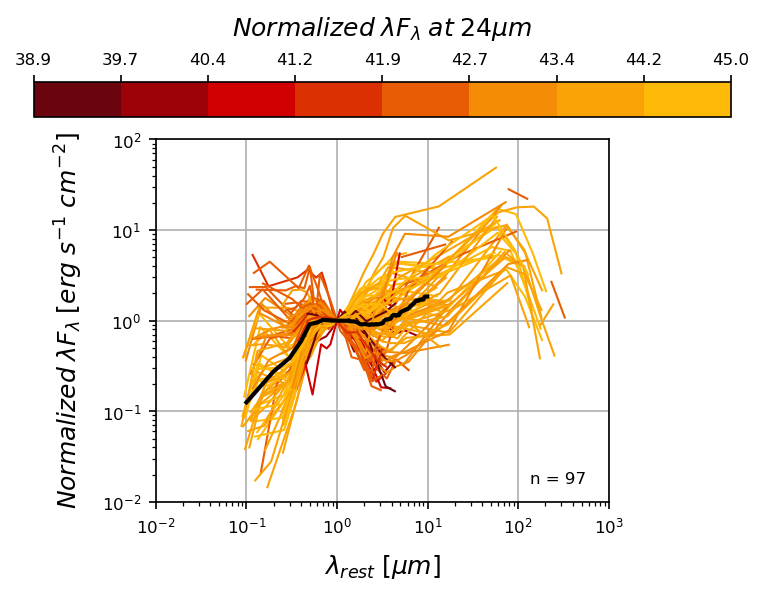

In [28]:
PlotSED_Row(
        x=[     
            # panelData['RED']['xp'][0]
            panelData['RED']['x']
            # agnInfo_byZ['$0 < z \\leq 1$']['RED']['Rest Wavelength'] #* 1E-4
        ],
        y=[     
            # panelData['RED']['yp'][0]
            panelData['RED']['y']
            # agnInfo_byZ['$0 < z \\leq 1$']['RED']['Energy Density Normalized at 1um'] #* 1E-4
        ],            
        z=[     
            # panelData['RED']['zp'][0]
            panelData['RED']['z']
            # agnInfo_byZ['$0 < z \\leq 1$']['RED']['Luminosity at 1um']
        ],
        cmapKey=['r','r','r','r','r',],      
        # save=adp.path_fig+'\\v2_SED_3tall_z01.png',      
        orientWide=True,
        ymin=10**-2,
        ymax=10**2,
)

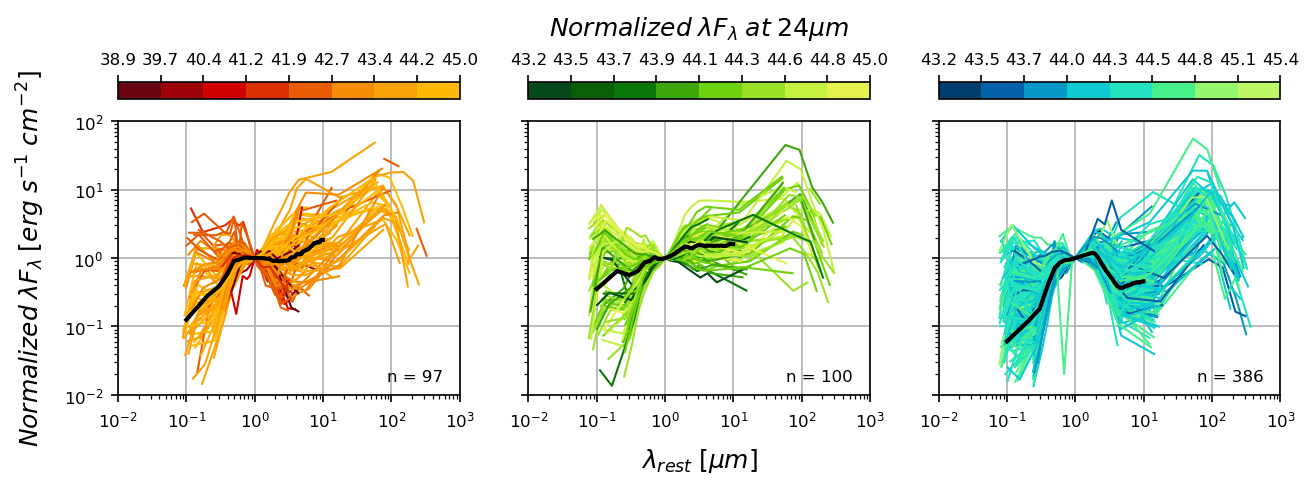

In [33]:
PlotSED_Row(
        x=[     
            # panelData['RED']['xp'][0]
            panelData['RED']['x'],
            panelData['GRN']['x'],
            panelData['BLU']['x']
            # agnInfo_byZ['$0 < z \\leq 1$']['RED']['Rest Wavelength'] #* 1E-4
        ],
        y=[     
            # panelData['RED']['yp'][0]
            panelData['RED']['y'],
            panelData['GRN']['y'],
            panelData['BLU']['y']
            # agnInfo_byZ['$0 < z \\leq 1$']['RED']['Energy Density Normalized at 1um'] #* 1E-4
        ],            
        z=[     
            # panelData['RED']['zp'][0]
            panelData['RED']['z'],
            panelData['GRN']['z'],
            panelData['BLU']['z']
            # agnInfo_byZ['$0 < z \\leq 1$']['RED']['Luminosity at 1um']
        ],
        cmapKey=['r','g','b'],      
        # save=adp.path_fig+'\\v2_SED_3tall_z01.png',      
        orientWide=True,
        ymin=10**-2,
        ymax=10**2,
)